In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 80

ng =5

ng_adju = (/ 1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

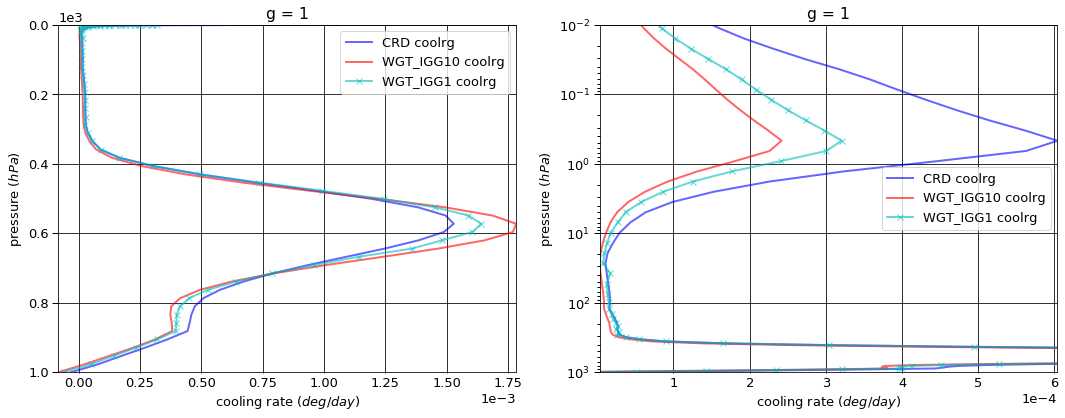

# Figure: cooling rate g-group 2

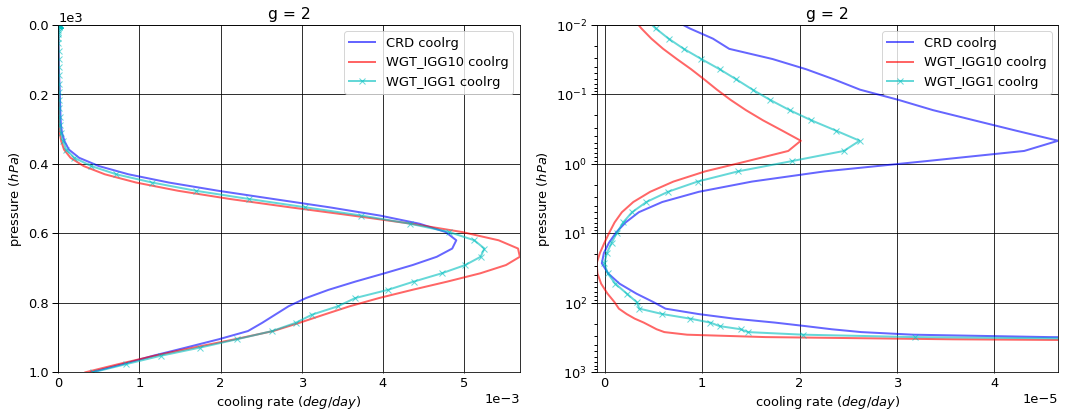

# Figure: cooling rate g-group 3

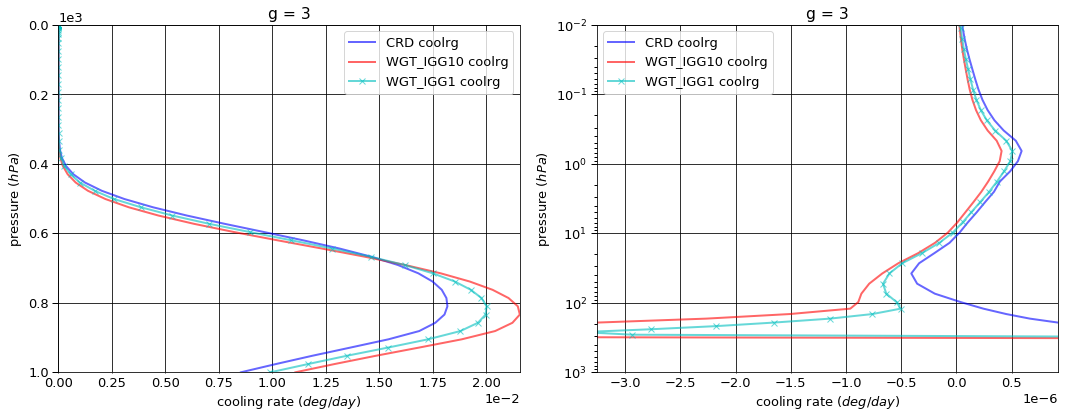

# Figure: cooling rate g-group 4

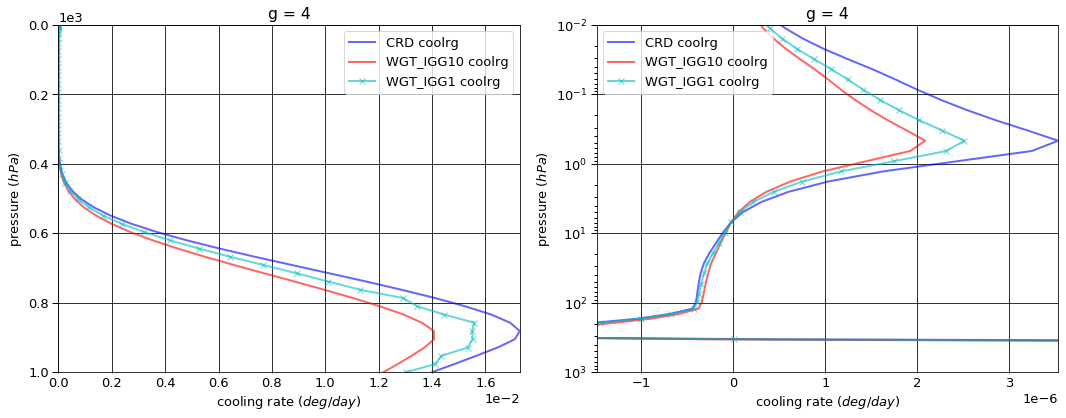

# Figure: cooling rate g-group 5

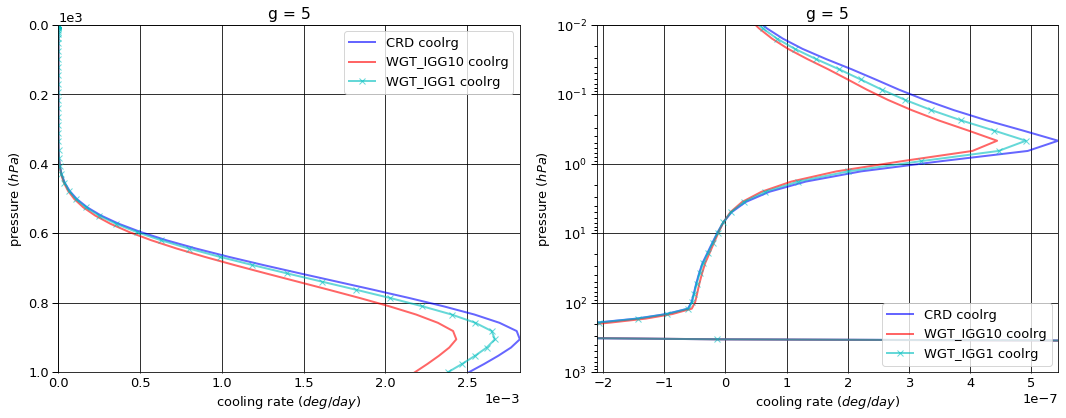

# Figure: cooling rate g-group total

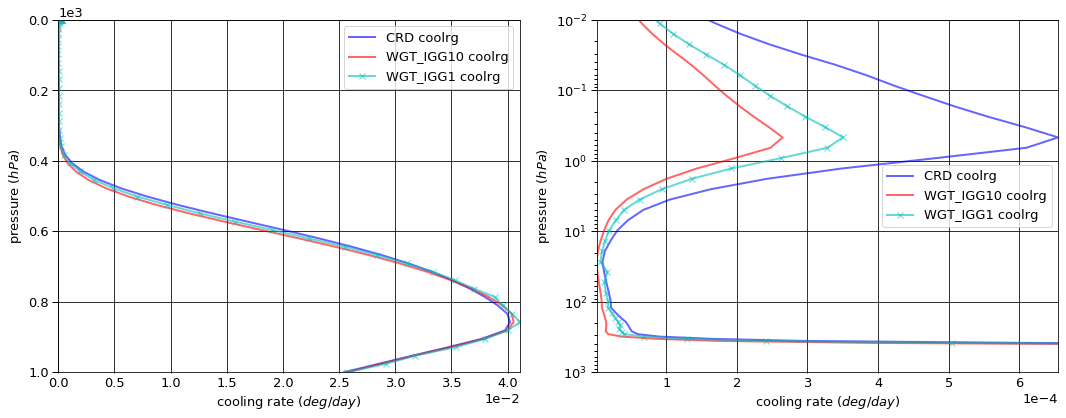

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.056607  0.000000  -0.056607
  1013.0   76     -0.073570  0.073699   0.000128
2 0.0      1      -0.226907  0.000000  -0.226907
  1013.0   76     -0.265373  0.245986  -0.019387
3 0.0      1      -1.299887  0.000000  -1.299887
  1013.0   76     -1.359135  0.880184  -0.478951
4 0.0      1      -6.271852  0.000000  -6.271852
  1013.0   76     -6.289902  0.668447  -5.621455
5 0.0      1     -10.931312  0.000000 -10.931312
  1013.0   76    -10.933543  0.104737 -10.828806


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.056618  0.000000  -0.056618
  1013.0   76     -0.073570  0.074776   0.001206
2 0.0      1      -0.229489  0.000000  -0.229489
  1013.0   76     -0.265373  0.263330  -0.002043
3 0.0      1      -1.310223  0.000000  -1.310223
  1013.0   76     -1.359135  0.946155  -0.412980
4 0.0      1      -6.277327  0.000000  -6.277327
  1013.0   76     -6.289902  0.532479  -5.757423
5 0.0      1     -10.931623  0.000000 -10.931623
  1013.0   76    -10.933543  0.090247 -10.843296


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.056173  0.000000  -0.056173
  1013.0   76     -0.073570  0.074650   0.001080
2 0.0      1      -0.228353  0.000000  -0.228353
  1013.0   76     -0.265373  0.258900  -0.006473
3 0.0      1      -1.304863  0.000000  -1.304863
  1013.0   76     -1.359135  0.919958  -0.439177
4 0.0      1      -6.274521  0.000000  -6.274521
  1013.0   76     -6.289902  0.601698  -5.688204
5 0.0      1     -10.931414  0.000000 -10.931414
  1013.0   76    -10.933543  0.099175 -10.834368


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000011  0.000000 -0.000011
  1013.0   76     0.000000  0.001077  0.001077
2 0.0      1     -0.002582  0.000000 -0.002582
  1013.0   76     0.000000  0.017344  0.017344
3 0.0      1     -0.010336  0.000000 -0.010336
  1013.0   76     0.000000  0.065971  0.065971
4 0.0      1     -0.005475  0.000000 -0.005475
  1013.0   76     0.000000 -0.135968 -0.135968
5 0.0      1     -0.000311  0.000000 -0.000311
  1013.0   76     0.000000 -0.014490 -0.014490


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000434  0.000000  0.000434
  1013.0   76     0.000000  0.000951  0.000951
2 0.0      1     -0.001446  0.000000 -0.001446
  1013.0   76     0.000000  0.012914  0.012914
3 0.0      1     -0.004976  0.000000 -0.004976
  1013.0   76     0.000000  0.039774  0.039774
4 0.0      1     -0.002669  0.000000 -0.002669
  1013.0   76     0.000000 -0.066749 -0.066749
5 0.0      1     -0.000102  0.000000 -0.000102
  1013.0   76     0.000000 -0.005562 -0.005562

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.282565e-05
  1001.112500 75    -3.173915e-05
2 0.000312    1     -7.014659e-07
  1001.112500 75     4.025939e-04
3 0.000312    1     -3.773562e-09
  1001.112500 75     8.535494e-03
4 0.000312    1     -1.990111e-07
  1001.112500 75     1.398999e-02
5 0.000312    1     -1.882878e-08
  1001.112500 75     2.509822e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.177986e-06
  1001.112500 75    -8.313821e-05
2 0.000312    1     -3.607549e-07
  1001.112500 75     3.336346e-04
3 0.000312    1     -7.442052e-09
  1001.112500 75     1.108444e-02
4 0.000312    1     -1.224831e-07
  1001.112500 75     1.217218e-02
5 0.000312    1     -1.580273e-08
  1001.112500 75     2.179677e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      4.917815e-06
  1001.112500 75    -6.048749e-05
2 0.000312    1     -1.471712e-07
  1001.112500 75     4.257225e-04
3 0.000312    1     -7.216899e-09
  1001.112500 75     9.918337e-03
4 0.000312    1     -1.436415e-07
  1001.112500 75     1.301178e-02
5 0.000312    1     -1.745985e-08
  1001.112500 75     2.381633e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.164767e-05
  1001.112500 75    -5.139906e-05
2 0.000312    1      3.407110e-07
  1001.112500 75    -6.895934e-05
3 0.000312    1     -3.668490e-09
  1001.112500 75     2.548942e-03
4 0.000312    1      7.652795e-08
  1001.112500 75    -1.817813e-03
5 0.000312    1      3.026054e-09
  1001.112500 75    -3.301442e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.907838e-06
  1001.112500 75    -2.874834e-05
2 0.000312    1      5.542948e-07
  1001.112500 75     2.312854e-05
3 0.000312    1     -3.443338e-09
  1001.112500 75     1.382843e-03
4 0.000312    1      5.536959e-08
  1001.112500 75    -9.782150e-04
5 0.000312    1      1.368929e-09
  1001.112500 75    -1.281881e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.786565,0.000000,-18.786565
1013.0,76,-18.921523,1.973052,-16.948471



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.805279,0.000000,-18.805279
1013.0,76,-18.921523,1.906987,-17.014536



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.795323,0.000000,-18.795323
1013.0,76,-18.921523,1.954381,-16.967142



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.018715,0.000000,-0.018715
1013.0,76,0.000000,-0.066065,-0.066065



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.008758,0.000000,-0.008758
1013.0,76,0.000000,-0.018672,-0.018671


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000012
1001.112500,75,0.025406



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,6.715033e-07
1001.112500,75,2.568679e-02



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000005
1001.112500,75,0.025677



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.000281



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.000271


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003900,0.003887
2,0.014113,0.014018
3,0.072188,0.071801
4,0.334275,0.332263
5,0.575525,0.578030


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.799596e-22
2,5.890970e-23
3,1.370238e-23
4,7.182832e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.799596e-22,NaN,0.003900,0.003887,0.003900,0.003887,100.0
2,5.890970e-23,0.101576,0.014113,0.014018,0.018013,0.017905,100.0
3,1.370238e-23,0.232600,0.072188,0.071801,0.090200,0.089706,600.0
4,7.182832e-25,0.052420,0.334275,0.332263,0.424475,0.421970,600.0
5,3.765264e-26,0.052420,0.575525,0.578030,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
